<center>
    <h1>MultiHead-Attention Mechanism</h1>
</center>

# Brief Recap
**Multi-head attention** mechanism was introduced in 2017 in the paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) by Ashish Vaswani, Noam Shazeer and others.
Multihead Attention is a key concept in the field of deep learning, specifically in the realm of Transformer architectures. It allows the model to focus on different parts of the input sequence simultaneously, enhancing its ability to capture relationships between elements in the data.

# Architecture

<img src='assets/multi-head-attention.png' width=400>

The Multihead Attention mechanism involves several key steps:

1. **Input Embeddings**: The input is first embedded into a higher-dimensional space.
2. **Linear Projections**: The embeddings are linearly projected into three matrices—Query (Q), Key (K), and Value (V).
3. **Scaled Dot-Product Attention**:
   - Calculate the dot product between Q and K to determine how much focus each element should receive.
   - Scale the dot product by the square root of the dimension of Q/K.
   - Apply a softmax function to get the attention scores.
   - Multiply the attention scores with V to get the weighted output.
4. **Concatenation of Heads**: Each attention head performs the above steps independently, and their outputs are concatenated.
5. **Final Linear Projection**: The concatenated output is passed through a final linear layer to get the desired dimensions.

### Formula
The attention score can be computed as:
$$ \text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V $$

Where:
- \( Q \): Query Matrix
- \( K \): Key Matrix
- \( V \): Value Matrix
- \( d_k \): Dimension of the Key vector


# Applications
Multihead Attention has diverse applications across several domains:

### 1. Natural Language Processing (NLP)
   - **Machine Translation**: Allows models to translate languages by focusing on relevant words.
   - **Text Summarization**: Extracts key information from text for summarization.

### 2. Computer Vision
   - **Image Classification**: Attention mechanisms help models focus on important regions in images.
   - **Object Detection**: Enhances the ability of models to detect objects in images by focusing on different regions.

### 3. Time Series Analysis
   - **Forecasting**: Helps models capture long-term dependencies in sequential data for accurate predictions.

### 4. Reinforcement Learning
   - **Policy Optimization**: Attention mechanisms can be used to improve the focus on key states in an environment.


# Implementation of MultiHead-Attention using TensorFlow



## Approach 1


### Defining the Attention Mechanism

**Step 1: Calculate the Dot Product**

```shell
matmul_qk = tf.matmul(query, key, transpose_b=True)
```

 This calculates the similarity or relevance between the query and each key in the input sequence. The resulting matrix `matmul_qk` stores these similarity scores, which are then used in subsequent steps of the attention mechanism to determine the attention weights.

**Step 2: Scale the Scores**<br>
```shell
depth = tf.cast(tf.shape(key)[-1], tf.float32)
scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)
```
To stabilize gradients during training, we scale the scores by $\sqrt{dk}$ (the dimension of keys). This helps to keep the values of the dot product in a range where the softmax function is effective.

**Step 3: Apply the Mask (Optional)**<br>
The mask is used to prevent certain tokens from being attended to, such as padding tokens. If a position should not be attended to, it is set to a large negative value, making its softmax output near zero.

**Step 4: Apply Softmax**<br>

```shell
attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
```

The softmax function converts these scores into probabilities, highlighting the most relevant positions for each query. The output is a probability distribution over the sequence length.

**Step 5: Weighted Sum**<br>
```shell
output = tf.matmul(attention_weights, value)
```

Finally, we multiply these probabilities (attention weights) by the value matrix to get a weighted sum. This weighted sum is the attention output.

In [1]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Calculates the attention scores between the query, key, and value matrices.

    Args:
        query: The query matrix (Q).
        key: The key matrix (K).
        value: The value matrix (V).
        mask: Optional mask to apply to the attention scores.

    Returns:
        output: The result of applying attention scores to the value matrix.
        attention_weights: The attention scores after applying softmax.
    """
    # Step 1: Calculate the dot product between Q and K^T (transpose of K)
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Step 2: Scale the dot products by the square root of the key dimension
    depth = tf.cast(tf.shape(key)[-1], tf.float32)  # Dimension of the key vector
    scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)

    # Step 3: Apply the mask (if provided) to the scaled attention logits
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Step 4: Apply softmax to get the attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Step 5: Multiply the attention weights with the value matrix to get the output
    output = tf.matmul(attention_weights, value)

    return output, attention_weights


### Defining MultiHead-Attention Layer

The `MultiHeadAttention` class extends the scaled dot-product attention mechanism by applying multiple attention heads.

**1. Initialization**:

* `d_model` is the dimension of the input embeddings.
* `num_heads` is the number of attention heads.
* We ensure d_model is divisible by `num_heads` because each head will handle a fraction of the total dimension (`depth = d_model // num_heads`).

**2. Linear Projections:**

* Dense layers (`self.wq`, `self.wk`, `self.wv`) are used to project the input tensors into Query (Q), Key (K), and Value (V) matrices.
* These projections are then split into multiple heads.

**3. Splitting into Heads:**

* The `split_heads()` method reshapes the projected Q, K, and V matrices into smaller matrices for each head.
* Each head has a shape of (`batch_size`, `num_heads`, `seq_len`, `depth`), allowing parallel computation of attention for different parts of the input.

**4. Scaled Dot-Product Attention:**

* The `scaled_dot_product_attention()` function is applied to each head to compute the attention output.
* The result is transposed back to match the original input shape.

**5. Concatenation:**

* The outputs of all heads are concatenated together.
* This step aggregates the different perspectives each attention head has learned.

**6. Final Linear Layer:**

* A dense layer (`self.dense`) projects the concatenated output back to the desired output dimensions (`d_model`).
* This allows the multi-head output to be in the same format as the original input, making it compatible for subsequent layers in a Transformer model.


In [2]:
from tensorflow.keras.layers import Layer

class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # Ensure that the d_model is divisible by num_heads
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # Dense layers to project inputs to queries, keys, and values
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        # Dense layer to combine all the attention heads
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Splits the input tensor into multiple heads.

        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            batch_size: Size of the input batch.

        Returns:
            x: Transposed tensor of shape (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # Step 1: Linear projections for Q, K, V
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # Step 2: Split into multiple heads
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len, depth)

        # Step 3: Apply scaled dot-product attention
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Step 4: Concatenate the heads
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # Step 5: Final linear layer
        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)

        return output, attention_weights


2025-01-19 11:09:50.973838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 11:09:50.973921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 11:09:50.975909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 11:09:50.989995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 11:09:52.954032: W tensorflow/compiler/tf2

## Example Usage
Let's implement a simplified example of a multihead attention layer using dummy data, and then visualize the attention weights to see how the model distributes attention across the sequence.



### 1. Create Dummy Data

Generate some simple sequences as input.

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
dummy_data = np.random.rand(1, 10, 64)  # (batch_size, seq_len, d_model)
dummy_data = tf.convert_to_tensor(dummy_data, dtype=tf.float32)


2025-01-19 11:09:55.792948: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-19 11:09:55.793130: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: ml
2025-01-19 11:09:55.793148: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: ml
2025-01-19 11:09:55.793341: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.120.0
2025-01-19 11:09:55.793385: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.120.0
2025-01-19 11:09:55.793394: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.120.0


### 2. Instantiate and Apply the Multi-Head Attention layer



In [4]:
num_heads = 4
d_model = 64
mha = MultiHeadAttention(d_model, num_heads)

### 3. Forward Pass

Pass the dummy data through the attention layer to get the attention weights.

In [5]:
# Query, Key, and Value are all the same in this dummy example
output, attention_weights = mha(dummy_data, dummy_data, dummy_data, mask=None)

# Attention weights shape: (batch_size, num_heads, seq_len, seq_len)
print(f"Attention weights shape: {attention_weights.shape}")

Attention weights shape: (1, 4, 10, 10)


### Visualizing the Attention Weights:
* The output of each subplot shows how each attention head focuses on different positions in the sequence.
* Each heatmap displays the attention distribution, with brighter colors indicating higher attention weights.
* Rows represent query positions, and columns represent key positions.

This visualization helps us understand how attention heads distribute focus across different parts of the input sequence, making multihead attention a powerful mechanism for capturing relationships in sequences.

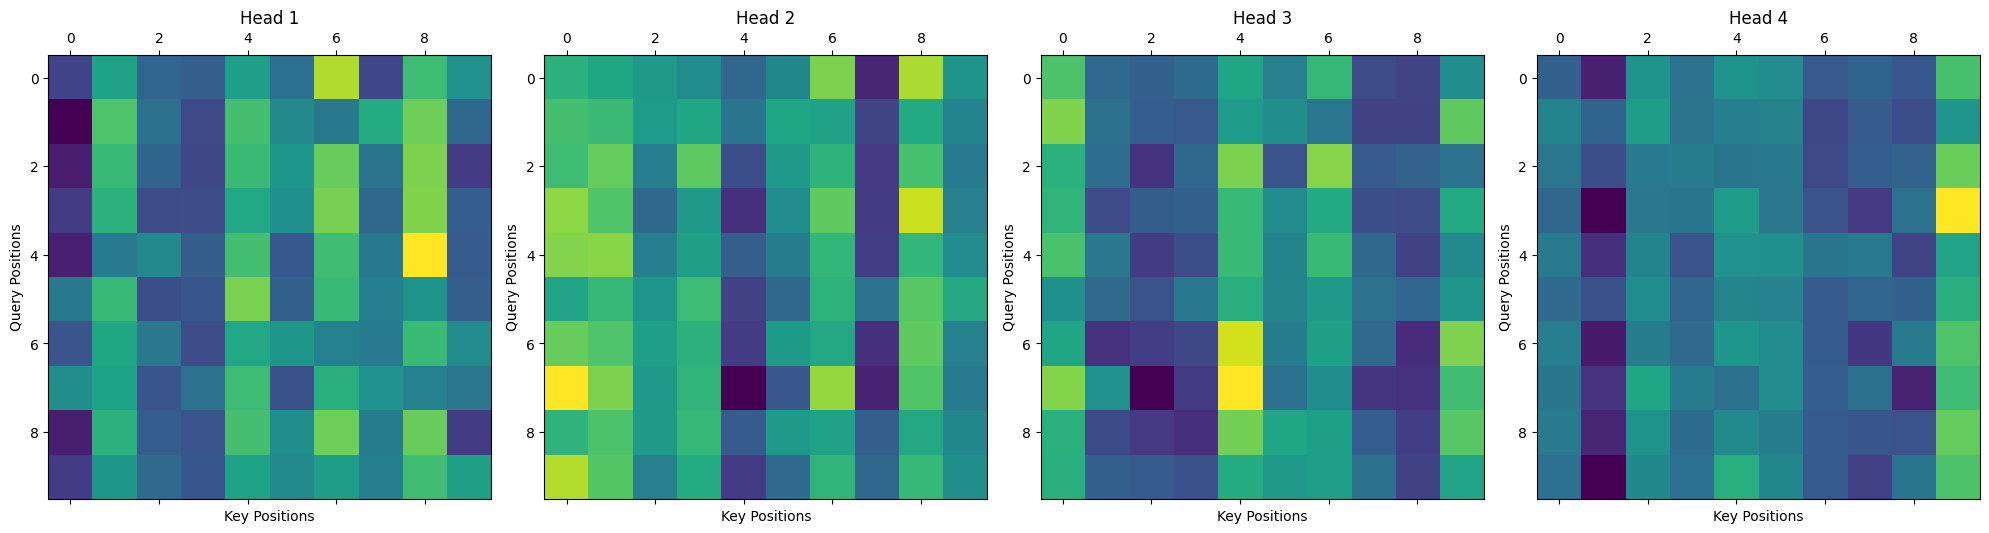

In [6]:
# Visualize the attention weights for each head
fig, axes = plt.subplots(1, num_heads, figsize=(20, 5))
for i in range(num_heads):
    ax = axes[i]
    ax.matshow(attention_weights[0, i].numpy(), cmap='viridis')
    ax.set_title(f'Head {i + 1}')
    ax.set_xlabel('Key Positions')
    ax.set_ylabel('Query Positions')
plt.tight_layout()
plt.show()

## Approach 2



Although, the above approach gives you more control in designing your attention mechanism, there is an alternate and more simpler way to do that.

```python
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
    dropout=0.0,
    use_bias=True)
```

**Arguments**
* **num_heads:** (Integer) The number of attention heads. This determines how many parallel attention mechanisms will be used.
* **key_dim:** (Integer) The dimension of the key, query, and value vectors. This is the size of each attention head.
* **value_dim:** (Optional Integer) The dimension of the value vectors. If not specified, it defaults to key_dim.
* **dropout:** (Optional Float) The dropout rate to apply to the attention weights.
* **use_bias:** (Optional Boolean) Whether to use bias vectors in the dense layers. Defaults to True.

**Call arguments**
* **query:** Tensor of shape (batch_size, seq_len_q, depth) representing the query.
* **value:** Tensor of shape (batch_size, seq_len_v, depth) representing the value.
* **key:** Tensor of shape (batch_size, seq_len_k, depth) representing the key.
* **attention_mask:** (Optional) A mask to apply to the attention weights.
* **return_attention_scores:** (Optional Boolean) Whether to return the attention scores along with the output. Defaults to False.

**Outputs:**

* **output:** Tensor of shape (batch_size, seq_len_q, value_dim) representing the output of the multi-head attention.
* **attention_scores:** (Optional) If return_attention_scores=True, a tensor of shape (batch_size, num_heads, seq_len_q, seq_len_k) representing the attention weights.



---



# SMS Spam Classification using Muli-Head Attention

<img src='https://miro.medium.com/v2/resize:fit:1400/1*oLszsXod-dV2c1NBqa8k7w.jpeg' width=500>

SMS spam classification is a crucial task to filter unwanted and potentially harmful messages. Traditional methods often rely on hand-crafted features and classical machine learning algorithms. In this approach, we will leverage the power of Multi-Head Attention to build a robust SMS spam classifier.

## Dataset Description

The [SMS Spam Collection](https://www.kaggle.com/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset) dataset contains 5574 English, real, and non-encoded messages. The SMS messages are thought-provoking and eye-catching. The dataset is useful for mobile phone spam research.

**Key characteristics:**

* **Content:** Upto 5000 records of original text messages classified as spam or not spam.
* **Size:** The full dataset contains around 5574 english, real and non-encoded messages.
* **Format:** The data is stored as text, and the code uses a tokenizer to convert words into numerical representations.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, MultiHeadAttention, Dropout, LayerNormalization, Input, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split


2025-01-19 11:11:13.424335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 11:11:13.424410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 11:11:13.426468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 11:11:13.442520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 11:11:15.453185: W tensorflow/compiler/tf2

### 1. Load and Preprocess data

In [13]:
# Load the dataset
data = pd.read_csv('sms_spam.csv', on_bad_lines='skip')
data['label'] = data['label'].apply(lambda x: 1 if x == 'spam' else 0)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['sms'], data['label'], test_size=0.2, random_state=42)


### 2. text Vectorization

We'll use `TextVectorization` to convert the text into integer tokens for the model.



In [14]:
# Parameters
vocab_size = 10000
sequence_length = 100
embedding_dim = 64

# Text vectorization layer
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vectorizer.adapt(X_train.values)

# Example vectorization
X_train_vectorized = vectorizer(X_train)


### 3. Build the model with Muli-Head Attention

We'll be utilizing the `tf.keras.layers.MultiHeadAttention` module to build our model. We'll be assigning **4 attention heads**.

In [15]:
def create_model(vocab_size, embedding_dim, sequence_length, num_heads):
    # Input layer
    inputs = Input(shape=(sequence_length,), dtype=tf.int32)

    # Embedding layer
    x = Embedding(vocab_size, embedding_dim)(inputs)

    # Multihead Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)  # Residual connection

    # Global pooling to reduce sequence length
    pooled_output = GlobalAveragePooling1D()(attention_output)

    # Dense layers for classification
    dense_output = Dense(64, activation='relu')(pooled_output)
    dense_output = Dropout(0.1)(dense_output)
    outputs = Dense(1, activation='sigmoid')(dense_output)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
num_heads = 4
model = create_model(vocab_size=vocab_size, embedding_dim=embedding_dim, sequence_length=sequence_length, num_heads=num_heads)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


**Key Features**

* **Input Layer:** It takes an input tensor representing the vectorized SMS messages, with a shape of (sequence_length,).
Embedding Layer: It utilizes an Embedding layer to convert the integer-encoded words into dense vector representations. This allows the model to capture semantic relationships between words.
* **Multi-Head Attention:** The core of the model is the MultiHeadAttention layer, which enables it to attend to different parts of the input sequence simultaneously. It helps in capturing complex relationships and dependencies within the text.
* **Residual Connection and Layer Normalization:** A residual connection is implemented by adding the attention output to the original input, and then applying layer normalization. This aids in training deeper networks by mitigating the vanishing gradient problem and improving information flow.
* **Global Average Pooling:** A GlobalAveragePooling1D layer is used to reduce the sequence length to a fixed-size vector, capturing the overall essence of the message.
* **Dense Layers:** Two dense layers are employed for classification, with the first using a ReLU activation and the second using a sigmoid activation for binary classification (spam or ham).
* **Dropout:** Dropout layers are added after the attention and dense layers to prevent overfitting and improve generalization performance.
* **Output:** The model outputs a single value between 0 and 1, representing the probability of the input message being spam.


### 4. Training and Evaluation

In [16]:
# Prepare the training data
X_train_vectorized = vectorizer(X_train)
X_test_vectorized = vectorizer(X_test)

# Train the model
history = model.fit(X_train_vectorized, y_train, epochs=5, batch_size=32, validation_data=(X_test_vectorized, y_test))


Epoch 1/5
140/140 [==============================] - 23s 138ms/step - loss: 0.0092 - accuracy: 0.9946 - val_loss: 2.3934e-05 - val_accuracy: 1.0000
Epoch 2/5
140/140 [==============================] - 20s 140ms/step - loss: 3.4782e-05 - accuracy: 1.0000 - val_loss: 5.7487e-06 - val_accuracy: 1.0000
Epoch 3/5
140/140 [==============================] - 13s 96ms/step - loss: 1.3994e-05 - accuracy: 1.0000 - val_loss: 2.3231e-06 - val_accuracy: 1.0000
Epoch 4/5
140/140 [==============================] - 8s 58ms/step - loss: 7.9998e-06 - accuracy: 1.0000 - val_loss: 1.1850e-06 - val_accuracy: 1.0000
Epoch 5/5
140/140 [==============================] - 8s 58ms/step - loss: 5.1152e-06 - accuracy: 1.0000 - val_loss: 7.1097e-07 - val_accuracy: 1.0000


In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_vectorized, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


35/35 [==============================] - 1s 20ms/step - loss: 7.1097e-07 - accuracy: 1.0000
Test Accuracy: 100.00%


### Inference

In [19]:
# Predict on new samples
new_messages = [
    "Hey, can we reschedule our meeting to tomorrow?"
]
new_messages_vectorized = vectorizer(new_messages)
predictions = model.predict(new_messages_vectorized)

# Print the predictions
for i, message in enumerate(new_messages):
    print(f"Message: '{message}' - Prediction: {'Spam' if predictions[i] > 0.5 else 'Not Spam'}")


1/1 [==============================] - 0s 19ms/step
Message: 'Hey, can we reschedule our meeting to tomorrow?' - Prediction: Not Spam
